In [ ]:
# type: ignore 

# SoccerCPD Part 1 : Formation Change Point Detection

## Section 4.1 : Calculating the Sequence of Role-Adjacency Matrices

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from scipy.spatial import Delaunay
from matplotlib.patches import Circle

In [120]:
import numpy as np

def make_toy_dataset(T=50, noise_def=0.1, noise_att=0.15):
    """
    Formation change simulation:
    - Start = 3-3
    - End   = 2-4 with a fast overlapping defender & accelerated attackers
    """

    P = np.zeros((T, 6, 2))
    t = np.linspace(0, 1, T)
    alpha = t[:, None]

    # === INITIAL POSITIONS (3-3) ===
    start_positions = np.array([
        [0.0,  -30.0],   # 0 CB
        [-20.0,-32.0],  # 1 LB
        [20.0, -32.0],  # 2 RB (overlap forward)

        [0.0,   5.0],    # 3 CAM
        [-15.0, 8.0],    # 4 LW
        [15.0,  8.0],    # 5 RW
    ])

    # === FINAL POSITIONS (2-4) ===
    end_positions = np.array([
        [-10.0, -20.0],  # 0 LCB
        [20.0,  -16.0],  # 1 RCB
        [10.0,  15.0],   # 2 RB bombing to wing

        [-5.0,  14.0],   # 3 CAM pushes up
        [-18.0, 30.0],   # 4 LW higher
        [18.0,  26.0],   # 5 RW higher
    ])

    # === SPEED MULTIPLIERS ===
    speed = np.ones(6)
    speed[0] = 0.7  # CB slower push
    speed[1] = 0.8  # LB slower push
    speed[2] = 1.9  # RB bombs forward (FAST)
    speed[3] = 1.3  # CAM runs forward
    speed[4] = 1.4  # LW accelerates
    speed[5] = 1.4  # RW accelerates

    # === Noise per player ===
    noise = np.array([noise_def, noise_def, noise_def,
                      noise_att, noise_att, noise_att])

    for i in range(6):
        alpha_i = np.clip(alpha * speed[i], 0, 1)
        base_traj = (1 - alpha_i) * start_positions[i] + alpha_i * end_positions[i]
        P[:, i, :] = base_traj + noise[i] * np.random.randn(T, 2)

    return P


In [121]:
def draw_field(ax, 
               pitch_width=60, pitch_length=100, 
               circle_radius=9.15,
               goal_width=5, goal_depth=2):
    # Half-dimensions
    half_w = pitch_width / 2
    half_l = pitch_length / 2
    
    # Set axes limits
    ax.set_xlim(-half_w, half_w)
    ax.set_ylim(-half_l, half_l)
    ax.set_aspect("equal")
    
    # ===== MIDFIELD & CIRCLE =====
    ax.plot([-half_w, half_w], [0, 0], color="black", linewidth=2)
    ax.add_patch(Circle((0, 0), circle_radius, fill=False, color="black", linewidth=2))
    
    # ===== GOAL (TOP) =====
    gx1, gx2 = -goal_width/2, goal_width/2
    gy_front = half_l
    gy_back = half_l - goal_depth
    
    # Crossbar
    ax.plot([gx1, gx2], [gy_front, gy_front], color="black", linewidth=3)
    # Depth posts
    ax.plot([gx1, gx1], [gy_front, gy_back], color="black", linewidth=3)
    ax.plot([gx2, gx2], [gy_front, gy_back], color="black", linewidth=3)
    # Back of goal
    ax.plot([gx1, gx2], [gy_back, gy_back], color="black", linewidth=3)
    
    # Labels
    ax.set_xlabel("Width (X)")
    ax.set_ylabel("Length (Y)")
    ax.set_title("Football Field")
    
    return ax

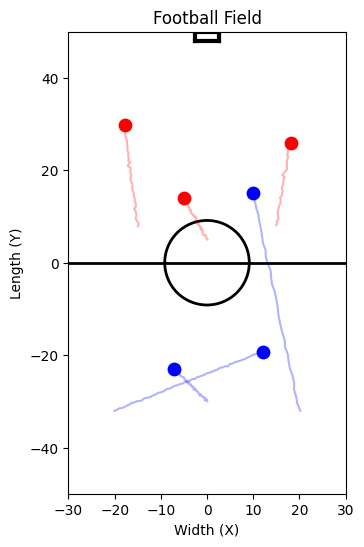

In [122]:
P = make_toy_dataset(T=60)

fig, ax = plt.subplots(figsize=(10,6))
draw_field(ax)

defenders = [0,1,2]
attackers = [3,4,5]

# Defenders in blue
for idx in defenders:
    ax.plot(P[:, idx, 0], P[:, idx, 1], color="blue", alpha=0.3)
    ax.scatter(P[-1, idx, 0], P[-1, idx, 1], color="blue", s=80)

# Attackers in red
for idx in attackers:
    ax.plot(P[:, idx, 0], P[:, idx, 1], color="red", alpha=0.3)
    ax.scatter(P[-1, idx, 0], P[-1, idx, 1], color="red", s=80)


In [126]:
def assign_roles(players, roles):
    cost = np.sum((players[:, None, :] - roles[None, :, :])**2, axis=2)
    _, col = linear_sum_assignment(cost)
    return col

def EM_roles_global(P, roles_init, n_iters=10):
    T, N, _ = P.shape
    roles = roles_init.copy().astype(float)
    assignments = np.zeros((T, N), dtype=int)

    for _ in range(n_iters):
        # ---- E-step ----
        for t in range(T):
            assignments[t] = assign_roles(P[t], roles)

        # ---- M-step ----
        new_roles = roles.copy()
        for r in range(N):
            pts = np.vstack([P[t][assignments[t]==r] for t in range(T) if np.any(assignments[t]==r)])
            if len(pts)>0:
                new_roles[r] = pts.mean(axis=0)
        roles = new_roles
    return roles, assignments

roles_init = P[0].copy()
roles, assignments = EM_roles_global(P, roles_init)


In [130]:
assignments

array([[0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [1, 0, 2, 3, 4, 5],
       [1, 0, 2, 3, 4, 5],
       [1, 0, 2, 3, 4, 5],
       [1, 0, 2, 3, 4, 5],
       [1, 0, 2, 3, 4, 5],
       [1, 0, 2, 3, 4, 5],
 

In [ ]:
def compute_role_positions(P, assignments):
    T, N, _ = P.shape
    R = np.zeros((T, N, 2))
    for t in range(T):
        for i in range(N):
            R[t, assignments[t,i]] = P[t,i]
    return R

roles_traj = compute_role_positions(P, assignments)


In [10]:
def adjacency_matrix_from_positions(X):
    tri = Delaunay(X)
    N = len(X)
    A = np.zeros((N, N), dtype=int)
    for simplex in tri.simplices:
        for i in [0,1,2]:
            a, b = simplex[i], simplex[(i+1)%3]
            A[a,b] = A[b,a] = 1
    return A


In [11]:
t = 10  # example frame

A_player = adjacency_matrix_from_positions(P[t])
A_role   = adjacency_matrix_from_positions(roles_traj[t])


In [15]:
def find_swap_frame(P, assignments):
    """
    Finds a frame where two players 'swap' roles (unstable adjacency).
    We measure disagreement between adjacency on players vs roles.
    """
    T, N, _ = P.shape
    worst_t = 0
    max_diff = -1
    
    for t in range(T):
        A_player = adjacency_matrix_from_positions(P[t])
        R = compute_role_positions(P, assignments)
        A_role = adjacency_matrix_from_positions(R[t])
        
        diff = np.sum(np.abs(A_player - A_role))
        if diff > max_diff:
            max_diff = diff
            worst_t = t
    return worst_t

swap_t = find_swap_frame(P, assignments)
swap_t


38

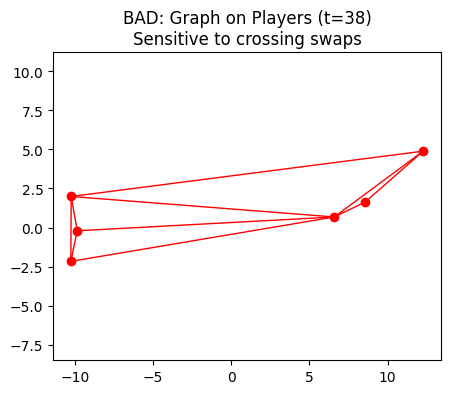

In [16]:
t = swap_t
A_player = adjacency_matrix_from_positions(P[t])

plt.figure(figsize=(5,4))
plt.scatter(P[t,:,0], P[t,:,1], c='red')
for i in range(6):
    for j in range(i+1,6):
        if A_player[i,j]:
            plt.plot([P[t,i,0], P[t,j,0]],
                     [P[t,i,1], P[t,j,1]], 'r-', linewidth=1)
plt.title(f"BAD: Graph on Players (t={t})\nSensitive to crossing swaps")
plt.axis('equal'); plt.show()


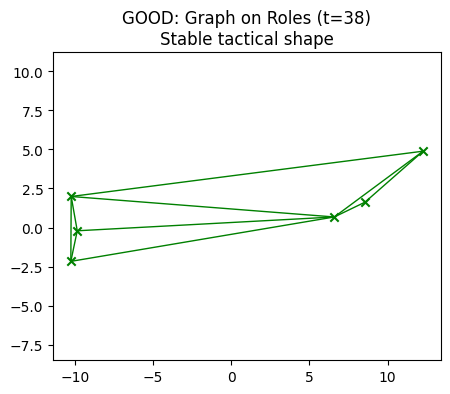

In [17]:
A_role = adjacency_matrix_from_positions(roles_traj[t])

plt.figure(figsize=(5,4))
plt.scatter(roles_traj[t,:,0], roles_traj[t,:,1], c='green', marker='x')
for i in range(6):
    for j in range(i+1,6):
        if A_role[i,j]:
            plt.plot([roles_traj[t,i,0], roles_traj[t,j,0]],
                     [roles_traj[t,i,1], roles_traj[t,j,1]], 'g-', linewidth=1)
plt.title(f"GOOD: Graph on Roles (t={t})\nStable tactical shape")
plt.axis('equal'); plt.show()


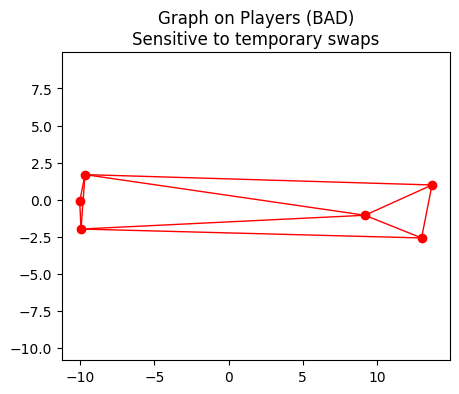

In [12]:
plt.figure(figsize=(5,4))
plt.scatter(P[t,:,0], P[t,:,1], c='red')
for i in range(6):
    for j in range(i+1,6):
        if A_player[i,j]:
            plt.plot([P[t,i,0], P[t,j,0]], [P[t,i,1], P[t,j,1]], 'r-', linewidth=1)
plt.title("Graph on Players (BAD)\nSensitive to temporary swaps")
plt.axis('equal'); plt.show()


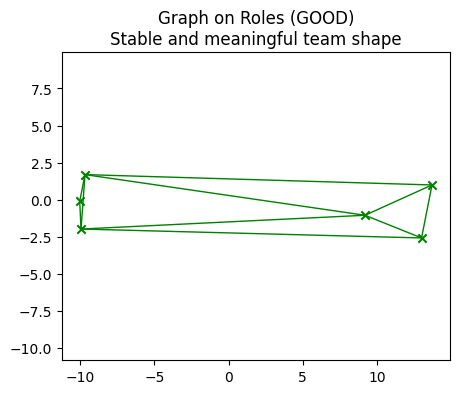

In [13]:
plt.figure(figsize=(5,4))
plt.scatter(roles_traj[t,:,0], roles_traj[t,:,1], c='green', marker='x')
for i in range(6):
    for j in range(i+1,6):
        if A_role[i,j]:
            plt.plot([roles_traj[t,i,0], roles_traj[t,j,0]], 
                     [roles_traj[t,i,1], roles_traj[t,j,1]], 'g-', linewidth=1)
plt.title("Graph on Roles (GOOD)\nStable and meaningful team shape")
plt.axis('equal'); plt.show()


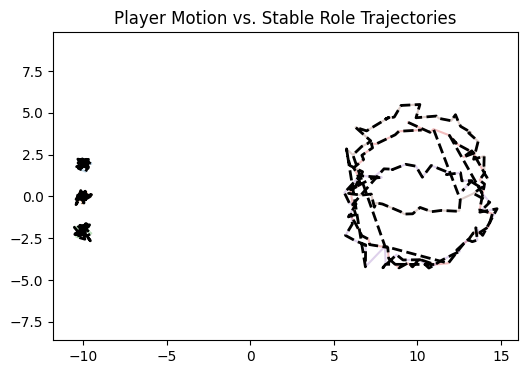

In [14]:
plt.figure(figsize=(6,4))
for i in range(6):
    plt.plot(P[:,i,0], P[:,i,1], alpha=0.3)   # messy players
plt.plot(roles_traj[:,:,0], roles_traj[:,:,1], 'k--', linewidth=2)  # stable roles
plt.title("Player Motion vs. Stable Role Trajectories")
plt.axis('equal'); plt.show()


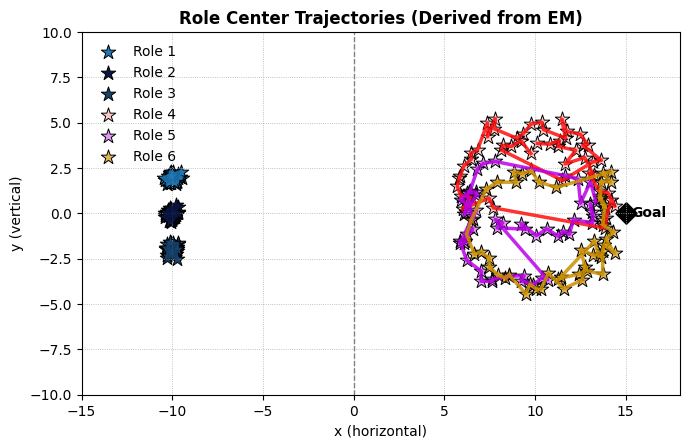

In [151]:
import matplotlib.pyplot as plt
import numpy as np

# Consistent tactical colors for roles (not tied to players)
role_colors = player_colors

fig, ax = plt.subplots(figsize=(7,5))

for r in range(roles_traj.shape[1]):
    traj = roles_traj[:, r, :]
    ax.plot(traj[:,0], traj[:,1],
            linewidth=2.5,
            color=role_colors[r],
            alpha=0.85)
    ax.scatter(traj[:,0], traj[:,1],
               marker='*',
               s=120,
               color=role_colors[r],
               edgecolors='black',
               linewidth=0.7,
               label=f"Role {r+1}")

# Goal (same as player plot)
goal = np.array([15, 0])
ax.scatter(goal[0], goal[1], marker="D", s=120, color="black")
ax.text(goal[0] + 0.3, goal[1] - 0.2, "Goal", fontsize=10, fontweight='bold')


ax.axvline(0, linestyle="--", linewidth=1, color="gray")

ax.set_title("Role Center Trajectories (Derived from EM)",
             fontsize=12, fontweight='bold')
ax.set_xlabel("x (horizontal)")
ax.set_ylabel("y (vertical)")

ax.set_xlim(-15, 18)
ax.set_ylim(-10, 10)
ax.set_aspect("equal", adjustable="box")
ax.grid(True, linestyle=":", linewidth=0.6)
ax.legend(loc="upper left", frameon=False)

plt.tight_layout()


In [2]:
def adjacency_matrix_from_positions(X):
    tri = Delaunay(X)
    N = len(X)
    A = np.zeros((N, N), dtype=int)
    for simplex in tri.simplices:
        for i in [0,1,2]:
            a, b = simplex[i], simplex[(i+1)%3]
            A[a,b] = A[b,a] = 1
    return A


In [3]:
t = 10  # example frame

A_player = adjacency_matrix_from_positions(P[t])
A_role   = adjacency_matrix_from_positions(roles_traj[t])


NameError: name 'P' is not defined

In [129]:
A_all = [adjacency_matrix_from_roles(roles_traj[t]) for t in range(roles_traj.shape[0])]


In [152]:
A_all[0]

array([[0, 1, 1],
       [1, 0, 1],
       [1, 1, 0]])